In [1]:
import os
from datetime import datetime

input_dir = "/eos/atlas/atlascerngroupdisk/phys-hdbs/diHiggs/combination/FullRun2Workspaces/"

# change your output directory here
date_str = datetime.now().strftime("%d_%m_%Y")
output_dir = os.path.join(os.getcwd(), f'output_{date_str}')

print(output_dir)

/afs/cern.ch/work/c/chlcheng/Repository/hh_combination_fw/tutorials/LegacyHHResonant/output_15_03_2024


In [2]:
output_dir = "/afs/cern.ch/work/c/chlcheng/Repository/hh_combination_fw/tutorials/LegacyHHResonant/output_07_10_2023"

## Step 1: Process channels

Here we want to process the channels bbbb, bbtautau and bbyy. The tasks to be performed are:
1. workspace modification ("modification")
2. Set upper limit ("limit")
3. Evaluate significance ("significance")

You can choose to opt out some of the tasks if needed.

In [2]:
import os
cmd = (f"HHComb process_channels -i {input_dir}/original/LegacyRun2/20230915/ "
       f"-o {output_dir}  -c bbbb,bbtautau,bbyy -n spin0 --file_expr '<mX[F]>' "
       "--config $hh_combination_fw_path/configs/task_options/Legacy2022/spin0_v3.yaml "
       "--unblind  --tasks modification,limit,significance")
print(cmd)
os.system(cmd)


RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt

[INFO] Scheduling tasks for the channel: bbbb
[INFO] Executing task "modification"
[INFO] Cache modified workspace "/afs/cern.ch/work/c/chlcheng/Repository/hh_combination_fw/tutorials/LegacyHHResonant/output_07_10_2023/workspace/spin0/bbbb/900.root".
[INFO] Cache modified workspace "/afs/cern.ch/work/c/chlcheng/Repository/hh_combination_fw/tutorials/LegacyHHResonant/output_07_10_2023/workspace/spin0/bbbb/1100.root".
[INFO] Cache modified workspace "/afs/cern.ch/work/c/chlcheng/Repository/hh_combination_fw/tutorials/LegacyHHResonant/output_07_10_2023/workspace/spin0/bbbb/251.root".
[INFO] Cache modified workspace "/afs/cern.ch/work/c/chlcheng/Repository/hh_combination_fw/tutorials/LegacyHHResonant/output_07_10_2023/workspace/spin0/bbbb/1300

0

## Step 2: Combination

Here we want to combine the channels bbbb, bbtautau and bbyy with full systematics correlation.
The tasks to be performed are:
1. workspace combination ("combination")
2. Set upper limit ("limit")
3. Evaluate significance ("significance")

You can choose to opt out some of the tasks if needed.

In [3]:
cmd = (f"HHComb combine_channels -i {output_dir} -n spin0 "
        "-s $hh_combination_fw_path/configs/correlation_schemes/Legacy2022/spin0_v2.json "
        "-c bbbb,bbtautau,bbyy --file_expr '<mX[F]>' "
        "--config $hh_combination_fw_path/configs/task_options/Legacy2022/spin0_v3.yaml "
        "--unblind --tasks combination,limit,significance")
print(cmd)
os.system(cmd)

HHComb combine_channels -i /afs/cern.ch/work/c/chlcheng/Repository/hh_combination_fw/tutorials/LegacyHHResonant/output_07_10_2023 -n spin0 -s $hh_combination_fw_path/configs/correlation_schemes/Legacy2022/spin0_v2.json -c bbbb,bbtautau,bbyy --file_expr '<mX[F]>' --config $hh_combination_fw_path/configs/task_options/Legacy2022/spin0_v3.yaml --unblind --tasks combination,limit,significance

RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt

[INFO] Registered the following parameter points and corresponding channels for combination
(mX=251)   : ['bbbb', 'bbtautau', 'bbyy']
(mX=260)   : ['bbbb', 'bbtautau', 'bbyy']
(mX=270)   : ['bbyy']
(mX=280)   : ['bbbb', 'bbtautau', 'bbyy']
(mX=290)   : ['bbyy']
(mX=300)   : ['bbbb', 'bbtautau', 'bbyy']
(mX=312.5) : ['bbyy']
(mX=325)   : ['bbtautau', 'bbyy'

0

## Step 3: Plotting

### Loading results

In [10]:
from typing import List, Optional
import os
import json
import pandas as pd
import numpy as np

# taken from HEP data
# for mX = [3500, 4000, 4500, 5000] GeV
bbbb_toy_limits = np.array([[1.087752763565852, 1.4444245219027092,
                             1.4444245219027092+0.31255600496947805/0.3392,
                             1.4444245219027092-0.129329738190612/0.3392,
                             1.4444245219027092+0.820931561035241/0.3392,
                             1.4444245219027092-0.2388881605685/0.3392],
                            [2.7082376588181605, 1.428776533018868,
                             1.428776533018868+0.273292/0.3392,
                             1.428776533018868-0.056061/0.3392,
                             1.428776533018868+0.741499/0.3392,
                             1.428776533018868-0.072175/0.3392],
                            [2.0445151596255307, 1.4471757075471698,
                             1.4471757075471698+0.257278/0.3392,
                             1.4471757075471698-0.075936/0.3392,
                             1.4471757075471698+0.699418/0.3392,
                             1.4471757075471698-0.140083/0.3392],
                            [1.4447149228597083, 1.5659994103773585,
                             1.5659994103773585+0.308864/0.3392,
                             1.5659994103773585-0.138319/0.3392,
                             1.5659994103773585+0.803083/0.3392,
                             1.5659994103773585-0.226212/0.3392]])

def load_channel_dfs(channels:List[str], dirname:str, output_type:str,
                     exclude_masses:Optional[List[float]]=None):
    channel_alias = {
        'combined_corr'   : 'combined/bbbb_bbtautau_bbyy-fullcorr',
        'combined_nocorr' : 'combined/bbbb_bbtautau_bbyy-nocorr',
    }
    basename_map = {
        'limit'        : 'nominal/limits_xsec_br.json',
        'significance' : 'observed/significance_mX.json' 
    }
    dfs = {}
    if exclude_masses is None:
        exclude_masses = []
    for channel in channels:
        channel_name = channel_alias.get(channel, channel)
        basename = basename_map[output_type]
        filename = os.path.join(dirname, output_type, "spin0", channel_name, basename)
        with open(filename) as file:
            data = json.load(file)
        df = pd.DataFrame(data).sort_values('mX')
        # only filter mass points for the combined result
        if 'combined' in channel:
            for mass in exclude_masses:
                df = df.query(f'(mX != {mass})')
        dfs[channel] = df
    return dfs

def load_limit_dfs(channels:List[str], dirname:str,
                   exclude_masses:Optional[List[float]]=None):
    dfs = load_channel_dfs(channels, dirname, 'limit', exclude_masses)
    cols = ['obs', '0', '1', '-1', '2', '-2']
    for channel in dfs:
        df = dfs[channel]
        # change to fb
        df.loc[:, cols] = df.loc[:, cols].multiply(1000, axis='index')
    # overwrite 4b, combined limits above 3.5 TeV with the toy results
    for channel in dfs:
        if channel not in ['bbbb', 'combined_corr', 'combined_nocorr']:
            continue
        df_tmp = dfs[channel].copy().set_index('mX')
        df_tmp.loc[[3500, 4000, 4500, 5000], cols] = bbbb_toy_limits
        dfs[channel] = df_tmp.reset_index()
    return dfs
        
def load_significance_dfs(channels:List[str], dirname:str,
                          exclude_masses:Optional[List[float]]=None,
                          pvalue_as_pc:bool=False,
                          remove_bad_status:bool=True):
    dfs = load_channel_dfs(channels, dirname, 'significance', exclude_masses)
    for channel in dfs:
        df = dfs[channel][['mX', 'significance', 'pvalue', 'status']].copy()
        # use percentage for pvalue
        if pvalue_as_pc:
            df.loc[:, ['pvalue']] = df.loc[:, ['pvalue']].multiply(100, axis='index')
        if remove_bad_status:
            df = df.query('status == 0')
        #else:
        #    df.loc[df['status']!=0, ['significance', 'pvalue']] = None
        dfs[channel] = df.dropna()
    return dfs

### Load limit results

In [30]:
channels = ['bbbb', 'bbyy', 'bbtautau', 'combined_corr']
exclude_masses = [425, 475, 650, 750, 850, 312.5, 337.5]

dfs = load_limit_dfs(channels, output_dir, exclude_masses)

### Upper Limit Plots

Most of the codes are just for aesthetics

<Figure size 640x480 with 0 Axes>

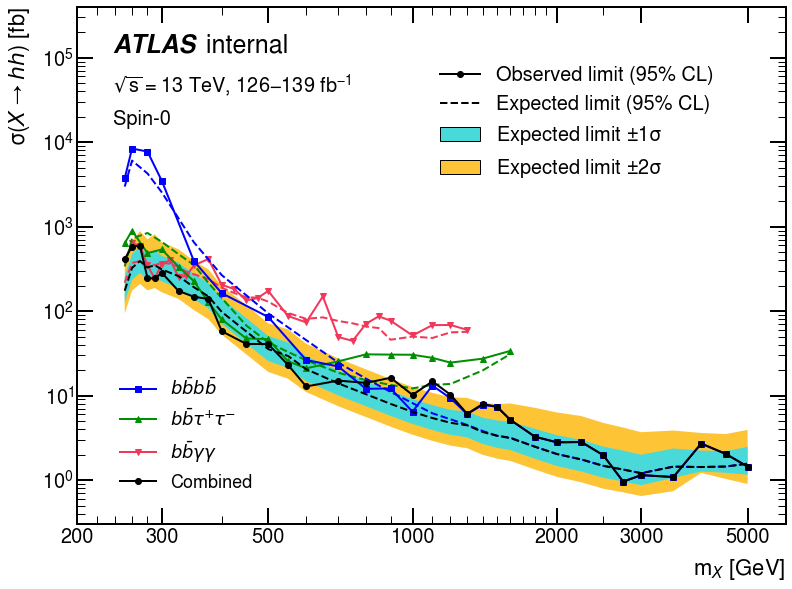

<Figure size 640x480 with 0 Axes>

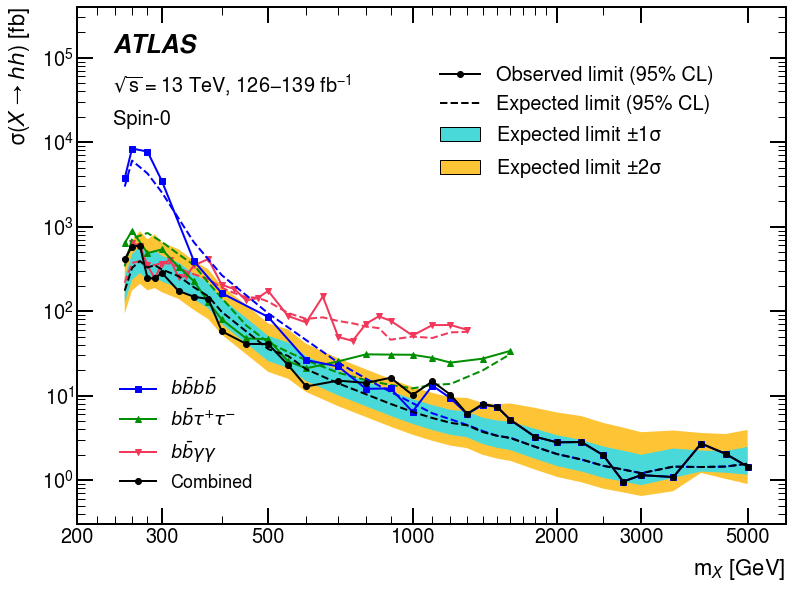

In [31]:
import numpy as np
import matplotlib.pyplot as plt

from quickstats.plots import UpperLimit2DPlot
from quickstats.utils.common_utils import combine_dict

channels = ['bbbb', 'bbyy', 'bbtautau', 'combined_corr']

# directory to which plots are saved
plot_dir = os.path.join(output_dir, 'plots')
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

xlabel = r'$m_{\it{X}}$ [GeV]'
ylabel = r'$\sigma ({\it{X}} \rightarrow {\it{hh}})$ [fb]'

styles = {
    'axis': {
        'tick_bothsides': True
    },
    'legend': {
        'loc': (0.5, 0.65)
    }
}


config = {
    'expected_plot_styles': {
        'linewidth': 2
    },
    'observed_plot_styles': {
        'linewidth': 2
    }
}

draw_kwargs = {
    'bbyy': {
        'logx': False,
        'logy': False,
        'ylim': (0, 1200),
        'xlim': (180, 1050)
    },
    'bbbb': {
        'logx': True,
        'logy': True,
        'ylim': (3e-1, 4e5),
        'xlim': (200, 6000)
    },
    'bbtautau': {
        'logx': False,
        'logy': True,
        'ylim': (3, 2e4),
        'xlim': (200, 1650)
    },
    'combined_corr': {
        'logx': True,
        'logy': True,
        'ylim': (3e-1, 4e5),
        'xlim': (200, 6000)
    },
    'combined_nocorr': {
        'logx': True,
        'logy': True,
        'ylim': (3e-1, 4e5),
        'xlim': (200, 6000)
    },
}

# custom tickmarks
ticks = {
    'bbbb': {
        'majorticks': [200, 300, 500, 1000, 2000, 3000, 5000],
        'minorticks': [200, 220, 240, 260, 280, 200, 300, 400, 500, 600, 700, 800, 900,
                       1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2500]
    },
    'combined_corr': {
        'majorticks': [200, 300, 500, 1000, 2000, 3000, 5000],
        'minorticks': [200, 220, 240, 260, 280, 200, 300, 400, 500, 600, 700, 800, 900,
                       1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2500]
    },
    'combined_nocorr': {
        'majorticks': [200, 300, 500, 1000, 2000, 3000, 5000],
        'minorticks': [200, 220, 240, 260, 280, 200, 300, 400, 500, 600, 700, 800, 900,
                       1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2500]
    }
}


latex_map = {
    'bbyy'            : r'$\it{b\bar{b}\gamma\gamma}$',
    'bbbb'            : r'$\it{b\bar{b}b\bar{b}}$',
    'bbtautau'        : r'$\it{b\bar{b}\tau\hspace{-0.15}{^+}\hspace{-0.2}{\tau}\hspace{-0.15}{^-}}$'
}

colors = {
    'bbyy'            : 'hh:darkpink',
    'bbbb'            : 'blue',
    'bbtautau'        : '#008f00'
}


default_analysis_label_options = {'loc': (0.05, 0.95),
                                  'fontsize':25, 'energy': '13 TeV', 
                                  'lumi': '139 fb$^{-1}$'}
custom_analysis_label_options = {
    'bbbb': {
        'lumi': '126 $-$ 139 fb$^{-1}$',
        'extra_text': r'$\mathrm{HH\rightarrow b\bar{b}b\bar{b}}$, Spin-0',
    },
    'bbyy': {
        'extra_text': r'$\mathrm{HH\rightarrow b\bar{b}\gamma\gamma}$, Spin-0',
    },
    'bbtautau': {
        'extra_text': r'$\mathrm{HH\rightarrow b\bar{b}\tau\hspace{0}{^+}\tau\hspace{0}{^-}}$, Spin-0',
    },
    'combined_corr'   : {
        'extra_text': r'Spin-0',
        'lumi': '126$-$139 fb$^{-1}$'
    },
    'combined_nocorr' : {
        'extra_text': r'Spin-0, NP uncorrelated',
        'lumi': '126$-$139 fb$^{-1}$'
    }
}

config_for_combined = {
    "bbbb": {
        "observed_plot_styles": {
            'marker': 's'
        }
    },
    "bbtautau": {
        "observed_plot_styles": {
            'marker': '^'
        }
    },
    "bbyy": {
        "observed_plot_styles": {
            'marker': 'v'
        }
    },
}


for status in ['internal', 'final']:
    #for channel in channels:
    for channel in ['combined_corr']:
        analysis_label_options = combine_dict(default_analysis_label_options, 
                                              custom_analysis_label_options.get(channel))
        analysis_label_options['status'] = status
        plotter = UpperLimit2DPlot(dfs[channel], styles=styles, config=config,
                                   analysis_label_options=analysis_label_options)
        # add limits from other channels in the combined case
        if 'combined' in channel:
            for channel_i in ['bbyy', 'bbtautau', 'bbbb']:
                plotter.add_data(dfs[channel_i],
                                 color_pallete={'expected': colors[channel_i],
                                                'observed': colors[channel_i]},
                                 labels={'observed': latex_map[channel_i]},
                                 draw_expected=True, draw_observed=True,
                                 config=config_for_combined.get(channel_i, None))
        ax = plotter.draw('mX', xlabel=xlabel, ylabel=ylabel, draw_hatch=False,
                          **draw_kwargs[channel])
        # hack into legend labels in the combined case
        if 'combined' in channel:
            # 0 is combined, 1 is bbyy, 2 is bbtautau, 3 is bbbb
            handles, labels = plotter.get_legend_handles_labels(idx=[0, 1, 2, 3])
            handles = np.array(handles, dtype=object)
            labels = np.array(labels, dtype=object)
            # obs, exp, 1 sigma, 2sigma
            main_handles = handles[[0, 1, 2, 3]]
            main_labels = labels[[0, 1, 2, 3]]
            aux_handles = handles[[-2, -4, -6, 0]]
            aux_labels = np.concatenate([labels[[-2, -4, -6]], ['Combined']])
            # bbyy obs, bbtautau obs, bbbb obs, combined obs
            aux_leg = plt.legend(aux_handles, aux_labels,
                                loc=(0.05, 0.05), fontsize=18)
            ax.legend(main_handles, main_labels, **plotter.styles['legend'])
            ax.add_artist(aux_leg)
        # custom ticks if applicable
        if channel in ticks:
            ax.set_xticks(ticks[channel]['majorticks'])
            ax.set_xticklabels(ticks[channel]['majorticks'])
            ax.set_xticks(ticks[channel]['minorticks'], minor=True)
            ax.set_xticklabels([], minor=True)
        outpath = os.path.join(plot_dir, status, f"limit_scan_{channel}.pdf")
        if not os.path.exists(os.path.dirname(outpath)):
            os.makedirs(os.path.dirname(outpath))
        plt.savefig(outpath, bbox_inches='tight')
        plt.show()

### Display limit tables

In [14]:
from IPython import display
rename_cols = {
    'mass': 'Mass [GeV]',
    '0': 'Expected [fb]',
    'obs': 'Observed [fb]'
}
# do not exclude masses
dfs = load_limit_dfs(channels, output_dir)
for channel in dfs:
    df = dfs[channel][['mX', '0', 'obs']].rename(columns=rename_cols)
    # this is due to changes in function name in newer pandas versions
    if hasattr(dfs[channel].style, 'hide'):
        #df = df.style.hide(axis='index').hide(axis='columns')
        df = df.style.hide(axis='index')
    else:
        df = df.style.hide_index()
    print(f'Channel: {channel}')
    display.display(df)

Channel: bbbb


mX,Expected [fb],Observed [fb]
251,2980.278959,3732.697975
260,6043.365694,8408.765475
280,4265.312679,7735.293631
300,2543.774147,3477.865244
350,652.400528,390.698651
400,266.896249,163.139725
500,94.262933,85.261484
600,45.398907,26.397816
700,24.577717,22.135058
800,15.875704,12.025830


Channel: bbyy


mX,Expected [fb],Observed [fb]
251.000000,217.434166,388.115988
260.000000,372.057713,639.542005
270.000000,391.442754,595.336784
280.000000,374.044261,346.985024
290.000000,349.705128,243.616837
300.000000,372.866598,363.310985
312.500000,364.505659,404.234528
325.000000,332.893881,251.502604
337.500000,292.958875,262.117802
350.000000,273.095479,347.906891


Channel: bbtautau


mX,Expected [fb],Observed [fb]
251,338.505414,638.498163
260,723.800314,896.952080
280,841.298374,486.509307
300,660.552905,536.857093
325,472.159087,335.201003
350,351.218012,225.947157
375,216.775032,128.472336
400,142.983528,79.736487
450,67.631291,47.487458
500,42.726054,46.550058


Channel: combined_corr


mX,Expected [fb],Observed [fb]
251.000000,174.514689,414.172403
260.000000,325.191918,580.887109
270.000000,391.442754,595.336784
280.000000,328.861940,245.686648
290.000000,349.705128,243.616837
300.000000,311.412233,284.322970
312.500000,364.505659,404.234528
325.000000,259.649325,173.307473
337.500000,292.958875,262.117802
350.000000,191.956394,148.090779


### Load significance results

In [11]:
channels = ['bbbb', 'bbyy', 'bbtautau', 'combined_corr']
exclude_masses = [425, 475, 650, 750, 850, 312.5, 337.5]
dfs = load_significance_dfs(channels, output_dir, exclude_masses=exclude_masses, remove_bad_status=False, pvalue_as_pc=False)

### Significance plots

<Figure size 640x480 with 0 Axes>

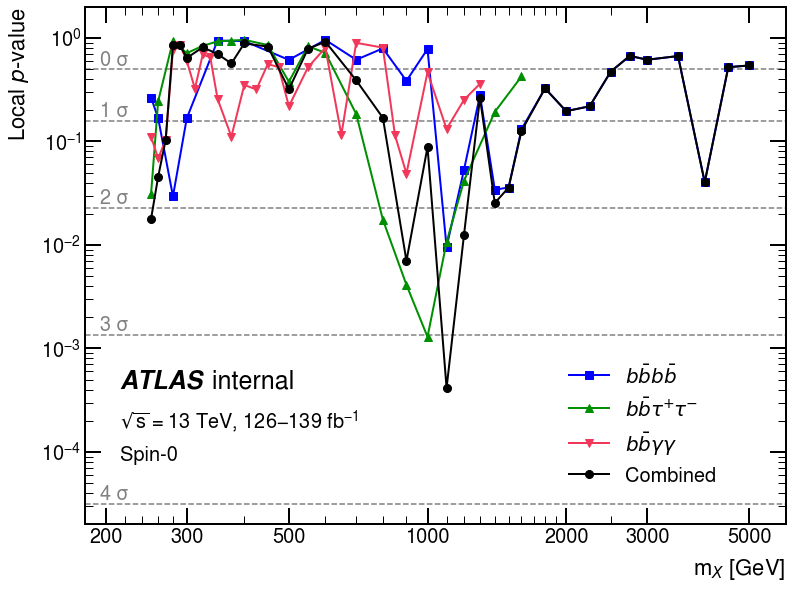

<Figure size 640x480 with 0 Axes>

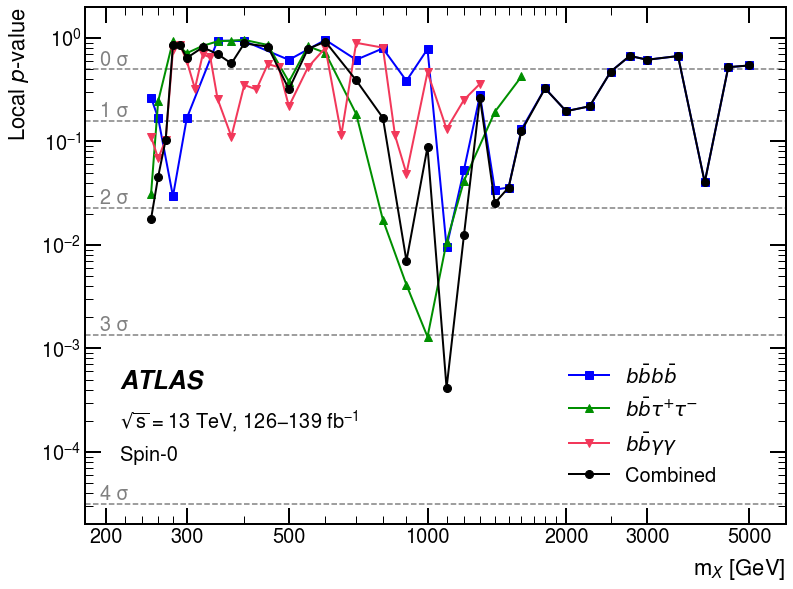

In [13]:
from quickstats.plots import General1DPlot
from quickstats.plots.template import create_transform
from quickstats.utils.common_utils import combine_dict
import matplotlib.pyplot as plt

#channels = ['combined_corr', 'combined_nocorr']
channels = ['combined_corr']

# directory to which plots are saved
plot_dir = os.path.join(output_dir, 'plots')
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

label_map = {
    'bbyy'            : r'$\it{b\bar{b}\gamma\gamma}$',
    'bbbb'            : r'$\it{b\bar{b}b\bar{b}}$',
    'bbtautau'        : r'$\it{b\bar{b}\tau\hspace{-0.15}{^+}\hspace{-0.2}{\tau}\hspace{-0.15}{^-}}$',
    'combined_corr'   : 'Combined',
    'combined_nocorr' : 'Combined',
}

styles = {
    'plot': {
        'marker': 'o',
        'markersize': 8,
        'linewidth': 2
    },
    'legend': {
        'loc': (0.68, 0.06)
    }
}

styles_map = {
    'bbyy' : {
        'color': 'hh:darkpink',
        'marker': 'v'
    },
    'bbbb': {
        'color':'blue',
        'marker': 's'
    },
    'bbtautau': {
        'color':'#008f00',
        'marker': '^'
    },
    'combined_corr': {
        'color': 'k',
        'marker': 'o'
    },
    'combined_nocorr': {
        'color': 'k',
        'marker': 'o'
    }
}

colors = {
    'bbyy'            : 'hh:darkpink',
    'bbbb'            : 'blue',
    'bbtautau'        : '#008f00'
}

sigma_values = {
    r'0 $\sigma$' : 0.5,
    r'1 $\sigma$' : 0.15865525393145707,
    r'2 $\sigma$' : 0.022750131948179216,
    r'3 $\sigma$' : 0.0013498980316300959,
    r'4 $\sigma$' : 3.167124183311998e-05   
}

sigma_text_styles = {
    'x': 0.02,
    'ha': 'left',
    'va': 'bottom',
    'color': 'gray'
}

draw_kwargs = {
    'xlabel': '$m_{\it{X}}$ [GeV]',
    'ylabel': r'Local $\it{p}$-value',
    'logx': True,
    'logy': True,
    'xmin': 180,
    'xmax': 6000,
    'ymin': 2e-5,
    'ymax': 2
}
extra_texts = {
    'combined_corr': 'Spin-0',#'Spin-0, NP correlated',
    'combined_nocorr': 'Spin-0, NP uncorrelated',
}

majorticks =  [200, 300, 500, 1000, 2000, 3000, 5000]
minorticks =  [200, 220, 240, 260, 280, 200, 300, 400, 500, 600, 700, 800, 900,
               1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2500]

for status in ['internal', 'final']:
    for channel in channels:
        analysis_label_options = {'loc': (0.05, 0.3),
                                  'status': status,
                                  'fontsize':25, 'energy': '13 TeV', 
                                  'lumi': '126$-$139 fb$^{-1}$',
                                  'extra_text': extra_texts[channel]}
        plotter = General1DPlot(dfs, label_map=label_map, styles=styles, styles_map=styles_map,
                                analysis_label_options=analysis_label_options)
        ax = plotter.draw('mX', 'pvalue', targets=['bbbb', 'bbtautau', 'bbyy', channel],
                          **draw_kwargs)
        ax.set_xticks(majorticks)
        ax.set_xticklabels(majorticks)
        ax.set_xticks(minorticks, minor=True)
        ax.set_xticklabels([], minor=True)
        transform = create_transform(transform_x="axis", transform_y="data")
        ax.hlines(sigma_values.values(), xmin=0, xmax=1, zorder=0, transform=transform,
                  color='gray', linestyle='--')
        text_styles = combine_dict(plotter.styles['text'], sigma_text_styles)
        for label, value in sigma_values.items():
            ax.text(y=value , s=label, **text_styles, transform=transform)
        outpath = os.path.join(plot_dir, status, f"pvalue_{channel}.pdf")
        if not os.path.exists(os.path.dirname(outpath)):
            os.makedirs(os.path.dirname(outpath))
        plt.savefig(outpath, bbox_inches='tight')    
        plt.show()

### Display significance table (local)

In [43]:
from IPython import display
exclude_masses = [650, 750, 850]
channels = ['bbbb', 'bbtautau', 'bbyy', 'combined_corr']
dfs = load_significance_dfs(channels, output_dir, exclude_masses=exclude_masses,
                            remove_bad_status=False, pvalue_as_pc=True)
rename_cols = {
    'mass': 'Mass [GeV]',
    'significance': 'Significance (Observed)',
    'pvalue': 'Pvalue (Observed) [%]'
}
for channel in dfs:
    df = dfs[channel][['mX', 'significance', 'pvalue']].rename(columns=rename_cols).fillna("")
    # this is due to changes in function name in newer pandas versions
    if hasattr(dfs[channel].style, 'hide'):
        #df = df.style.hide(axis='index').hide(axis='columns')
        df = df.style.hide(axis='index')
    else:
        df = df.style.hide_index()
    print(f'Channel: {channel}')
    display.display(df)

Channel: bbbb


mX,Significance (Observed),Pvalue (Observed) [%]
251,0.630559,26.416447
260,0.958336,16.894656
280,1.887771,2.952835
300,0.965457,16.715804
350,-1.583149,94.330628
400,-1.495142,93.256136
500,-0.289941,61.406942
600,-1.732073,95.836972
700,-0.293589,61.546411
800,-0.817061,79.305328


Channel: bbtautau


mX,Significance (Observed),Pvalue (Observed) [%]
251,1.862109,3.129384
260,0.694466,24.369486
280,-1.540607,93.829376
300,-0.562770,71.320417
325,-0.992032,83.940909
350,-1.455239,92.719848
375,-1.581843,94.315735
400,-1.730418,95.822216
450,-1.059247,85.525632
500,0.313141,37.708686


Channel: bbyy


mX,Significance (Observed),Pvalue (Observed) [%]
251.000000,1.221309,11.098448
260.000000,1.486569,6.856440
270.000000,1.260163,10.380537
280.000000,-0.701863,75.861766
290.000000,-1.048058,85.269406
300.000000,-0.257835,60.173287
312.500000,0.456229,32.411250
325.000000,-0.503236,69.260067
337.500000,-0.382664,64.901554
350.000000,0.651052,25.750634


Channel: combined_corr


mX,Significance (Observed),Pvalue (Observed) [%]
251.000000,2.098177,1.794475
260.000000,1.689888,4.552467
270.000000,1.260163,10.380537
280.000000,-1.053247,85.388603
290.000000,-1.048058,85.269406
300.000000,-0.359850,64.052042
312.500000,0.456229,32.411250
325.000000,-0.885895,81.216291
337.500000,-0.382664,64.901554
350.000000,-0.522588,69.936939


### Calculate global significance

In [3]:
channels = ['bbbb', 'bbyy', 'bbtautau', 'combined_corr']
exclude_masses = [425, 475, 650, 750, 850, 312.5, 337.5]
dfs = load_significance_dfs(channels, output_dir, exclude_masses=exclude_masses, remove_bad_status=True, pvalue_as_pc=False)

In [5]:
import pandas as pd
import numpy as np
from quickstats.maths.statistics import get_global_pvalue_significance

rename_cols = {
    'N_up': 'N downcrossing',
    'p_global': 'Global PValue',
    'Z_global': 'Global Significance',
    'Z_global_errhi': 'Global Significance +1 sigma',
    'Z_global_errlo': 'Global Significance -1 sigma'
}

def load_global_significance_df(input_dfs, Z_refs=(0, 1, 2)):
    dfs = {}
    columns = list(rename_cols)
    renamed_columns = list(rename_cols.values())
    multicol_arrays = [[], []]
    # this is just to change the dtype back to int
    N_up_idx = [] 
    for i, Z_ref in enumerate(Z_refs):
        multicol_arrays[0].extend([f'Z_ref = {Z_ref}'] * len(columns))
        multicol_arrays[1].extend(renamed_columns)
        if 'N_up' in columns:
            N_up_idx.append(i*len(columns) + columns.index('N_up'))
    multicol = pd.MultiIndex.from_arrays(multicol_arrays)
    for channel, input_df in input_dfs.items():
        data = []
        for Z_ref in Z_refs:
            data_Z_ref = get_global_pvalue_significance(input_df['mX'].values,
                                                        pvalue_local=input_df['pvalue'].values,
                                                        Z_ref=Z_ref)
            df = pd.DataFrame(data_Z_ref)[columns]
            df = df.rename(columns=rename_cols)
            data.append(df.values)
        df = pd.DataFrame(np.concatenate(data, axis=1), columns=multicol)
        df[multicol[N_up_idx]] = df[multicol[N_up_idx]].astype('int32')
        dfs[channel] = df
    return dfs
#df = pd.DataFrame(result)
#df[['N_up', 'p_global', 'Z_global']].replace([np.inf, -np.inf], np.nan).fillna("").style.hide(axis='index').hide(axis='columns')

In [6]:
Z_dfs = load_global_significance_df(dfs)

Welcome to JupyROOT 6.26/08

RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt



### Display significance table (global)

In [7]:
from IPython import display
for channel in Z_dfs:
    df = Z_dfs[channel].replace([np.inf, -np.inf], np.nan).fillna("")
    # this is due to changes in function name in newer pandas versions
    if hasattr(dfs[channel].style, 'hide'):
        #df = df.style.hide(axis='index').hide(axis='columns')
        df = df.style.hide(axis='index')
    else:
        df = df.style.hide_index()
    print(f'Channel: {channel}')
    display.display(df)

Channel: bbbb


Channel: bbyy


Channel: bbtautau


Channel: combined_corr
